## An example how to build an LSTM language model with keras.
* Based on: http://adventuresinmachinelearning.com/keras-lstm-tutorial/
* We'll use a different set of parameters and data to make this managable on a CPU.

In [1]:
# import modules

from __future__ import division

import collections
import os
import numpy as np
import argparse
import tensorflow as tf
import keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import keras
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm, tqdm_notebook
from IPython.display import SVG
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.callbacks import History 
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Functions and classes

In [2]:
def history_plot(history, validation=True, figsize_=(20,10)):
    """Plot network metric history for traning and validation sets"""
    df = pd.DataFrame(history.history)
    num_epochs = df.shape[0]
    
    # Set figure size option
    # plt.rcParams['figure.figsize'] = figsize_
    # Why do I need to reset this everytime?
    plt.style.use('dark_background')
    plt.figure(figsize=figsize_)
    metrics_ = [x for x in df.columns.tolist() if 'val' not in x]
    num_metrics = len(metrics_)
    
    for i in range(0, num_metrics):
        plt.subplot(int(round(num_metrics/2)), 2, i+1)
        plt.plot(df[metrics_[i]].values, 'r')
        if validation:
            validation_metric = 'val_' + metrics_[i]
            plt.plot(df[validation_metric].values, 'g')
        plt.xticks(np.arange(0, num_epochs+1, 1.0))
        plt.xlabel("Num of Epochs")
        plt.ylabel(metrics_[i])
        plt.title("Training {0} vs Validation {1}".format(metrics_[i], metrics_[i]))
        plt.legend(['train','validation'])
    plt.tight_layout()
    plt.show()

In [3]:
def make_confusion_matrix(classifier_, x_test, y_test, figsize_=(20,10)):
    """Make a confusion matrix"""
    Y_pred = classifier_.predict(x_test)
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Compute the confusion matrix and store as a DataFrame
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    
    plt.figure(figsize=figsize_)
    # Set label font size
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})

In [4]:
def plot_model(model):
    return SVG(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [5]:
def read_words(filename):
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().decode("utf-8").replace("\n", "<eos>").split()

In [6]:
def build_vocabulary(filename):
    """A function to build the vocabulary from input data"""
    data = read_words(filename)
    
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    
    return word_to_id

In [7]:
def build_vocabulary_news(data):
    
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    
    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    
    return word_to_id

In [8]:
def file_to_word_ids(filename, word_to_id):
    """A function to build the word id representation of each file"""
    data = read_words(filename)
    
    return [word_to_id[word] for word in data if word in word_to_id]

In [9]:
def file_to_word_ids_news(data, word_to_id):
    """A function to build the word id representation of each file"""
    
    return [word_to_id[word] for word in data if word in word_to_id]

In [10]:
def load_data(data_path):
    # get the data paths
    train_path = os.path.join(data_path, "ptb.train.txt")
    valid_path = os.path.join(data_path, "ptb.valid.txt")
    test_path = os.path.join(data_path, "ptb.test.txt")
    
    # build the complete vocabulary and get the integer representation
    word_to_id = build_vocabulary(train_path)
    train_data = file_to_word_ids(train_path, word_to_id)
    valid_data = file_to_word_ids(valid_path, word_to_id)
    test_data = file_to_word_ids(test_path, word_to_id)
    vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))
    
    return train_data, valid_data, test_data, vocabulary, reversed_dictionary

In [11]:
# TODO: Fix up this text loading and cleaning.  We can use the functions we've already written for nlp preprocessing
def load_data_news(train_data, valid_data, test_data):
    train_data_ = ' '.join(train_data).decode("utf-8").replace("\n", "<eos>").split()
    valid_data_ = ' '.join(valid_data).decode("utf-8").replace("\n", "<eos>").split()
    test_data_ = ' '.join(test_data).decode("utf-8").replace("\n", "<eos>").split()
    
    # build the complete vocabulary and get the integer representation
    word_to_id = build_vocabulary_news(train_data_)
    train_data_ = file_to_word_ids_news(train_data_, word_to_id)
    valid_data_ = file_to_word_ids_news(valid_data_, word_to_id)
    test_data_ = file_to_word_ids_news(test_data_, word_to_id)
    vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))
    
    return train_data_, valid_data_, test_data_, vocabulary, reversed_dictionary

In [56]:
def make_text_lstm_network(vocabulary, hidden_size, input_length, num_lstms, dropout_size=None):
    """Function to assemble basic LSTM architecture to text sequences"""
    # Initialize the sequential model
    model = Sequential()
    
    # Add an embedding layer. This is the first layer of the input. This takes the input words (integers at this stage), and makes a embedding vectors.
    # We need to supply the input dimension.  In this case it's the size of the vocabulary
    # Then we need to supply the output dimension we want.  Here, it's the size of the hidden layers (dense layers)
    # And then we need to supply the input length, that is the number of steps/words in the sample.
    # We'll start with the default embedding initializer, which is uniform.
    model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
    
    # LSTM layers.  We need to provide the size of the hidden layers (forget gate, tanh, etc) and set return_sequences to True. This will output every output from the LSTM through 
    # the sequence as opposed to just the last output.
    for _ in range(num_lstms):
        model.add(LSTM(hidden_size, return_sequences=True))
    
    # If dropout is required
    if dropout_size:
        model.add(Dropout(dropout_size))
        
    # Now add the time distributed layer.  This adds an independent layer for each step in the sequence (or each time step, this is num_steps in this case)
    model.add(TimeDistributed(Dense(vocabulary)))
    
    # The acitivation of the dense time distributed layers will be softmax
    model.add(Activation('softmax'))
    
    # Return the model object
    return model

In [52]:
class KerasBatchGenerator(object):
    """A class to generate batches of data to use in a Keras LSTM"""
    
    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        # The num_steps variable is the number of words to be feed into the time distributed input layer.
        # i.e. it is the set of words the model will learn from to predict the next words in the sequence.
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        
        # This is the number of works to be skipped over before the next batch is taken from the data.
        self.skip_step = skip_step
        
        # We need a variable to track the progess of the batches sequentially as we move through the data set.
        # Once we reach the end of the data, we need to reset the index counter to zero to restart.
        self.current_idx = 0
    
    
    def generate(self):
        """Generate a batch"""
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # In this case, we need to reset the index
                    self.current_idx = 0
                # Setup the training sample: of size num_steps
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                # Get the sequence for the target.  It's the next set of words shifted by 1.
                # We'll design the model to predict the next word, so we need to increment the index by 1.
                temp_y = self.data[self.current_idx + 1: self.current_idx + self.num_steps + 1]
                # Convert the target sample to one-hot encoding
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y

## # Load the data. 

In [13]:
# We'll use the Penn Tree Bank dataset to start with.  It's pretty big, so we'll see how well we can handle it on cpu.
data_path = "simple-examples/data"

In [14]:
train_data, valid_data, test_data, vocabulary, reversed_dictionary = load_data(data_path)

In [15]:
train_data[0:5]

[9970, 9971, 9972, 9974, 9975]

In [16]:
valid_data[0:5]

[1132, 93, 358, 5, 329]

In [17]:
test_data[0:5]

[102, 14, 24, 32, 752]

In [18]:
vocabulary

10000

In [19]:
print(" ".join([reversed_dictionary[x] for x in train_data[:100]]))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate <eos> a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of


In [20]:
# what? 
print(" ".join([reversed_dictionary[x] for x in test_data[:10]]))

no it was n't black monday <eos> but while the


In [21]:
len(train_data)

929589

In [22]:
len(test_data)

82430

In [23]:
len(valid_data)

73760

In [24]:
# I might want to sample on the training data to make this more managable on my laptop...

## Alternative dataset
* Use the 20 newsgroup dataset as an alternative. This might be a bit more managable.

In [91]:
from sklearn.datasets import fetch_20newsgroups

In [162]:
cats = ['sci.space']

In [163]:
newsgroup_train = fetch_20newsgroups(subset='train', categories=cats)
newsgroup_test = fetch_20newsgroups(subset='test', categories=cats)

In [164]:
len(newsgroup_train.filenames)

593

In [165]:
len(newsgroup_test.filenames)

394

In [166]:
len(newsgroup_train.data[0])

1360

In [167]:
newsgroup_train_ = newsgroup_train.data[0:100]
newsgroup_valid_ = newsgroup_train.data[100:126]
newsgroup_test_ = newsgroup_test.data[0:50]

In [168]:
train_data, valid_data, test_data, vocabulary, reversed_dictionary = load_data_news(train_data=newsgroup_train_, valid_data=newsgroup_valid_, test_data=newsgroup_test_)

In [169]:
len(train_data)

27008

In [170]:
len(valid_data)

4534

In [171]:
len(test_data)

8378

In [172]:
vocabulary

10228

In [173]:
print(" ".join([reversed_dictionary[x] for x in train_data[:100]]))

From: henry@zoo.toronto.edu (Henry Spencer)<eos>Subject: Re: japanese moon landing?<eos>Organization: U of Toronto Zoology<eos>Lines: 21<eos><eos>In article <1qnb9tINN7ff@rave.larc.nasa.gov> C.O.EGALON@LARC.NASA.GOV (CLAUDIO OLIVEIRA EGALON) writes:<eos>>> there is no such thing as a stable lunar orbit<eos>><eos>>Is it right??? That is new stuff for me. So it means that you just can <eos>>not put a sattellite around around the Moon for too long because its <eos>>orbit will be unstable??? If so, what is the reason??? Is that because <eos>>the combined gravitacional atraction of the Sun,Moon and Earth <eos>>that does not provide a stable orbit around the Moon???<eos><eos>Any lunar satellite needs fuel to do regular orbit corrections, and


## Initialize the data generators

In [25]:
num_steps = 30
batch_size = 20

In [53]:
# Initialize the training data generator class
train_data_generator = KerasBatchGenerator(data=train_data, 
                                           num_steps=num_steps,
                                           batch_size=batch_size,
                                           vocabulary=vocabulary,
                                           skip_step=num_steps)

In [54]:
# Initialize the validation data generator class
valid_data_generator = KerasBatchGenerator(data=valid_data,
                                          num_steps=num_steps,
                                          batch_size=batch_size,
                                          vocabulary=vocabulary,
                                          skip_step=num_steps)

## Set network parameters

In [28]:
# The size of the hidden layers in the LSTMs. I.e. this is the number of layers to use in the forget gate, the tanh layer, etc...
hidden_size = 10

In [30]:
# We need to be careful with the size of the network.  We'll be luck to get anything reasonable on a cpu.  
model = make_text_lstm_network(vocabulary=vocabulary, hidden_size=hidden_size, input_length=num_steps, num_lstms=1, dropout_size=0.5)

In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [32]:
# summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 10)            100000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 10)            840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 10)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 10000)         110000    
_________________________________________________________________
activation_1 (Activation)    (None, 30, 10000)         0         
Total params: 210,840
Trainable params: 210,840
Non-trainable params: 0
_________________________________________________________________


In [33]:
# visualize the network architecture
sequential_model_to_ascii_printout(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####          30
           Embedding   emb | -------------------    100000    47.0%
                       #####     30   10
                LSTM   LLLLL -------------------       840     0.0%
                tanh   #####     30   10
             Dropout    | || -------------------         0     0.0%
                       #####     30   10
     TimeDistributed   ????? -------------------    110000    52.0%
             softmax   #####     30 10000


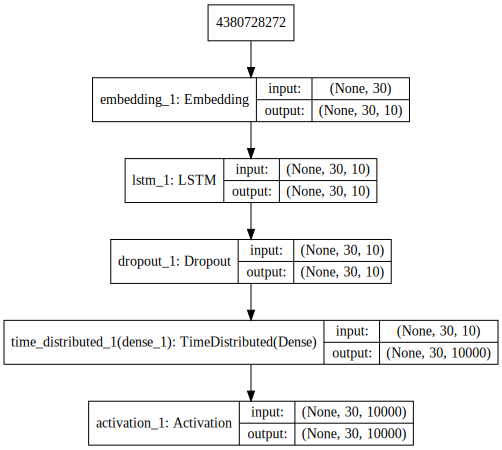

In [35]:
plot_model(model)

In [36]:
# So this model is pretty massive.  I doubt this will train on my laptop.  

In [37]:
checkpointer = ModelCheckpoint(filepath='/model-{epoch:02d}.hdf5', verbose=1)

In [38]:
# Before fitting, define the history object for the callbacks.
history_lstm = History()

In [39]:
# We'll need to be conservative with the number of epochs we train this on.  
num_epochs = 1

In [55]:
model.fit_generator(train_data_generator.generate(), 
                    len(train_data)//(batch_size * num_steps), 
                    num_epochs, 
                    validation_data=valid_data_generator.generate(), 
                    validation_steps=len(valid_data)//(batch_size * num_steps),
                    callbacks=[checkpointer, history_lstm])

Epoch 1/1
  79/1549 [>.............................] - ETA: 18:08 - loss: 9.0747 - categorical_accuracy: 0.0423

KeyboardInterrupt: 